C:\Users\franc\AppData\Local\Temp\ipykernel_32648\4161465187.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers, start="2018-01-01", end="2023-12-31")
[*********************100%***********************]  5 of 5 completed


Ticker           AAPL       AMZN       GOOG       MSFT       TSLA
Date                                                             
2018-01-02  40.381001  59.450500  52.935345  79.198334  21.368668
2018-01-03  40.373962  60.209999  53.804180  79.566887  21.150000
2018-01-04  40.561497  60.479500  53.999023  80.267189  20.974667
2018-01-05  41.023308  61.457001  54.785851  81.262383  21.105333
2018-01-08  40.870926  62.343498  55.019955  81.345299  22.427334


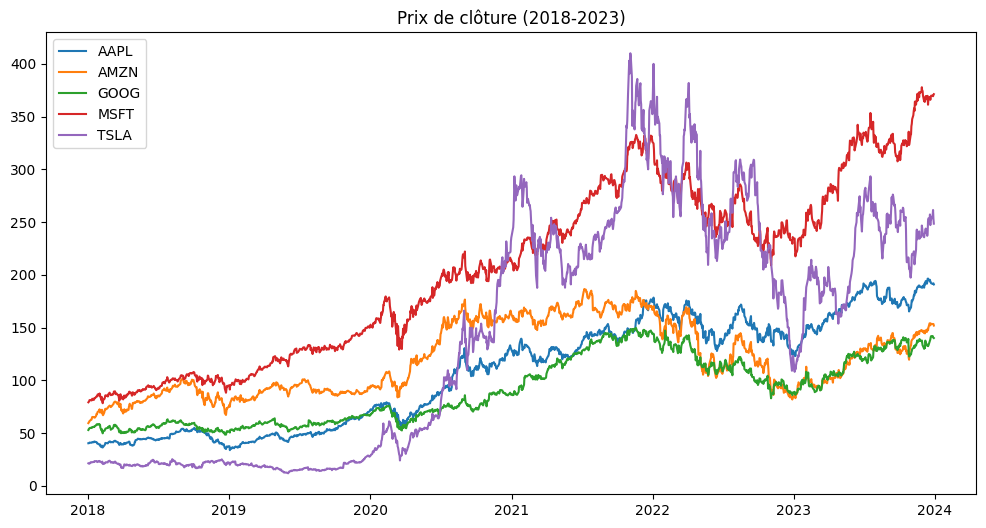

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Tickeurs
tickers = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA"]

# Télécharger les données (prix de clôture ajustés par défaut)
raw_data = yf.download(tickers, start="2018-01-01", end="2023-12-31")
data = raw_data["Close"]

# Afficher les 5 premières lignes
print(data.head())

# Visualiser l’évolution des prix
plt.figure(figsize=(12,6))
for col in data.columns:
    plt.plot(data.index, data[col], label=col)

plt.title("Prix de clôture (2018-2023)")
plt.legend()
plt.show()


Ticker          AAPL      AMZN      GOOG      MSFT      TSLA
Date                                                        
2018-01-03 -0.000174  0.012694  0.016280  0.004643 -0.010286
2018-01-04  0.004634  0.004466  0.003615  0.008763 -0.008325
2018-01-05  0.011321  0.016033  0.014466  0.012322  0.006210
2018-01-08 -0.003721  0.014322  0.004264  0.001020  0.060755
2018-01-09 -0.000115  0.004665 -0.000615 -0.000680 -0.008118


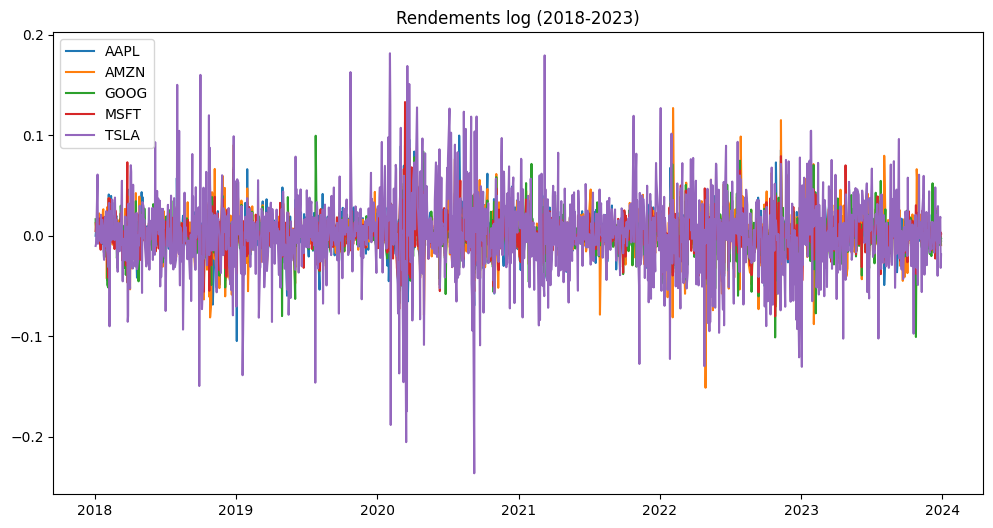

In [5]:
import numpy as np

# Rendements simples
returns = data.pct_change().dropna()

# Rendements log
log_returns = np.log(data / data.shift(1)).dropna()

# Afficher les 5 premières lignes
print(log_returns.head())

# Visualiser les rendements log
plt.figure(figsize=(12,6))
for col in log_returns.columns:
    plt.plot(log_returns.index, log_returns[col], label=col)

plt.title("Rendements log (2018-2023)")
plt.legend()
plt.show()


In [6]:
# --- A) Deux manières équivalentes de calculer le score momentum 126 jours ---

returns = data.pct_change()

# A1) Par produit de rendements (fenêtre rolling)
mom_prod = (1 + returns).rolling(window=126).apply(np.prod, raw=True) - 1

# A2) Par ratio de prix (équivalent, souvent plus simple/robuste)
mom_ratio = data / data.shift(126) - 1

# On utilisera mom = mom_ratio par simplicité
mom = mom_ratio

In [7]:
# Perf sur 252 jours en excluant les 21 derniers jours: P_{t-21}/P_{t-252} - 1
mom_12_1 = data.shift(21) / data.shift(252) - 1

In [8]:
def cross_sectional_signal(score_df, top_q=0.2, bottom_q=0.2):
    """
    Retourne un DataFrame de signaux dans {-1, 0, +1} :
    +1 pour les winners (top quantile), -1 pour les losers (bottom quantile), 0 sinon.
    """
    # Rangs percentiles par ligne (date)
    ranks = score_df.rank(axis=1, pct=True, method='first')

    long_mask = ranks >= (1 - top_q)
    short_mask = ranks <= bottom_q

    signal = pd.DataFrame(0, index=score_df.index, columns=score_df.columns, dtype=int)
    signal[long_mask] = 1
    signal[short_mask] = -1
    return signal

signal = cross_sectional_signal(mom, top_q=0.2, bottom_q=0.2)
signal.tail()


Ticker,AAPL,AMZN,GOOG,MSFT,TSLA
Date,,,,,
2023-12-22,0,1,1,0,-1
2023-12-26,0,1,1,0,-1
2023-12-27,0,1,1,0,-1
2023-12-28,0,1,1,0,-1
2023-12-29,0,1,1,0,-1


In [13]:
# Dernier jour de trading réellement disponible chaque mois
rebalance_dates = signal.groupby(signal.index.to_period('M')).tail(1).index

# On prend ces signaux de rebalancement, puis on les propage jusqu'au prochain
signal_m = signal.loc[rebalance_dates]
signal_m = signal_m.reindex(signal.index).ffill()

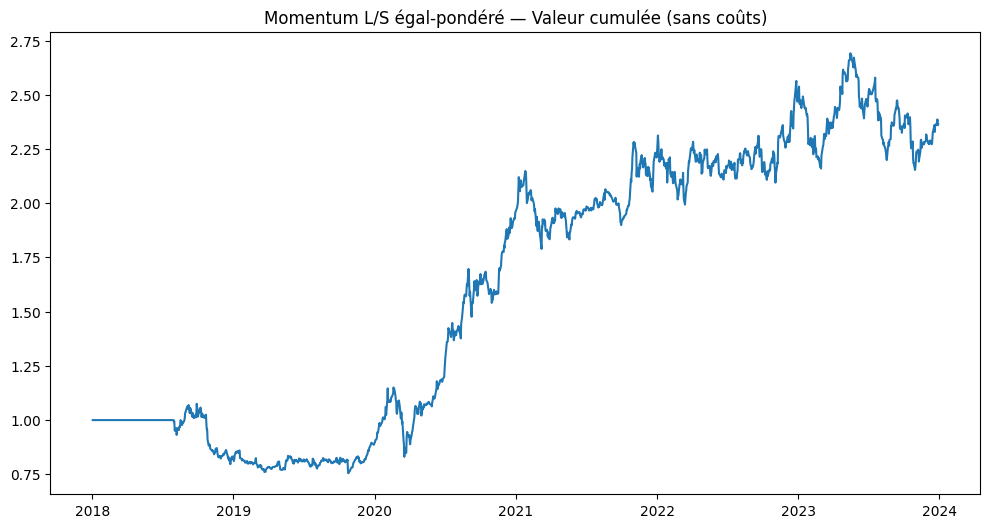

Sharpe (ann.): 0.76
Max Drawdown : -0.3


In [14]:
# PnL journalier égal-pondéré : moyenne des (signal * returns)
# (on aligne returns sur le même index)
common_index = signal_m.index.intersection(returns.index)
sig = signal_m.loc[common_index]
rets = returns.loc[common_index]

# Equal-weight: moyenne sur les colonnes non nulles
weights = sig.replace(0, np.nan)
weights = weights.div(weights.abs().sum(axis=1), axis=0)  # normalise somme des poids absolus à 1
weights = weights.fillna(0)

# PnL journalier
pnl = (weights * rets).sum(axis=1)

# Courbe de valeur cumulée
equity_curve = (1 + pnl).cumprod()

# Petit affichage
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(equity_curve.index, equity_curve.values)
plt.title("Momentum L/S égal-pondéré — Valeur cumulée (sans coûts)")
plt.show()

# Quelques métriques brèves
def sharpe(serie, freq=252):
    mu = serie.mean() * freq
    sigma = serie.std(ddof=1) * np.sqrt(freq)
    return mu / sigma if sigma != 0 else np.nan

def max_drawdown(cum_curve):
    roll_max = cum_curve.cummax()
    dd = cum_curve / roll_max - 1.0
    return dd.min()

print("Sharpe (ann.):", round(sharpe(pnl), 2))
print("Max Drawdown :", round(max_drawdown(equity_curve), 2))


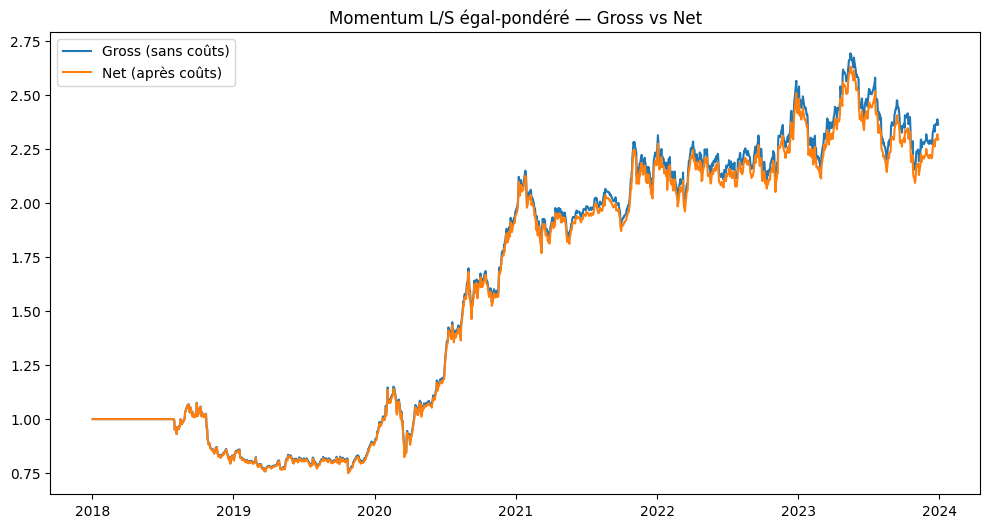

Sharpe gross: 0.76
Sharpe net  : 0.74
Max DD gross: -0.3
Max DD net  : -0.3
Turnover moyen (par jour): 0.0205
Turnover moyen (par an): 5.18


In [15]:
# --- Calcul du turnover entre deux rebalancements ---
# On ne calcule le turnover que les jours de rebalancement
# Pour les autres jours, turnover = 0

turnover = (weights.diff().abs().sum(axis=1)).fillna(0)

# --- Coût de transaction ---
# Hypothèse : 10 bps par unité de turnover
cost_per_unit = 0.001
costs = turnover * cost_per_unit

# --- PnL net après coûts ---
pnl_net = pnl - costs

# Courbe de valeur cumulée (net de coûts)
equity_curve_net = (1 + pnl_net).cumprod()

# --- Affichage comparatif ---
plt.figure(figsize=(12,6))
plt.plot(equity_curve.index, equity_curve, label="Gross (sans coûts)")
plt.plot(equity_curve_net.index, equity_curve_net, label="Net (après coûts)")
plt.title("Momentum L/S égal-pondéré — Gross vs Net")
plt.legend()
plt.show()

# --- Nouvelles métriques ---
print("Sharpe gross:", round(sharpe(pnl), 2))
print("Sharpe net  :", round(sharpe(pnl_net), 2))
print("Max DD gross:", round(max_drawdown(equity_curve), 2))
print("Max DD net  :", round(max_drawdown(equity_curve_net), 2))
print("Turnover moyen (par jour):", round(turnover.mean(), 4))
print("Turnover moyen (par an):", round(turnover.mean()*252, 2))


In [16]:
import numpy as np

def performance_report(pnl, equity_curve, turnover, freq=252):
    """
    Crée un rapport de performance format 'institutionnel'
    pnl : série des rendements du portefeuille
    equity_curve : série cumulée (valeur du portefeuille)
    turnover : série du turnover quotidien
    freq : 252 (jours de bourse), 12 (mensuel), etc.
    """
    ann_return = (1 + pnl).prod() ** (freq / len(pnl)) - 1
    ann_vol = pnl.std() * np.sqrt(freq)
    sharpe_ratio = ann_return / ann_vol if ann_vol > 0 else np.nan
    max_dd = max_drawdown(equity_curve)
    skew = pnl.skew()
    kurt = pnl.kurtosis()
    avg_turnover = turnover.mean() * freq

    report = pd.DataFrame({
        "Annual Return": [ann_return],
        "Annual Volatility": [ann_vol],
        "Sharpe Ratio": [sharpe_ratio],
        "Max Drawdown": [max_dd],
        "Skewness": [skew],
        "Kurtosis": [kurt],
        "Avg Turnover (per year)": [avg_turnover]
    }).T
    report.columns = ["Value"]
    return report

# Rapport gross
report_gross = performance_report(pnl, equity_curve, turnover)
# Rapport net
report_net = performance_report(pnl_net, equity_curve_net, turnover)

print("=== Rapport gross ===")
display(report_gross)

print("=== Rapport net (après coûts) ===")
display(report_net)


=== Rapport gross ===


,Value
Annual Return,0.154585
Annual Volatility,0.219558
Sharpe Ratio,0.704073
Max Drawdown,-0.298035
Skewness,-0.114214
Kurtosis,4.881572
Avg Turnover (per year),5.176938


=== Rapport net (après coûts) ===


,Value
Annual Return,0.148627
Annual Volatility,0.219554
Sharpe Ratio,0.676949
Max Drawdown,-0.301770
Skewness,-0.112966
Kurtosis,4.882432
Avg Turnover (per year),5.176938


### Interprétation des résultats

Les résultats de la stratégie momentum long/short égal-pondéré sur un univers de 5 actions (2018–2023) montrent une performance annualisée d'environ **15% brut** (14.8% net après coûts).  
Le **Sharpe ratio (~0.7)** reste positif, indiquant que le signal contient de l'information exploitable, même après prise en compte des frais de transaction.  

Néanmoins, plusieurs limites apparaissent :  
- La **volatilité annuelle (~22%)** est élevée par rapport au rendement net, ce qui limite l’attractivité de la stratégie.  
- Le **max drawdown (-30%)** est trop important pour être acceptable dans un cadre réel : un investisseur ne supporterait pas une telle perte.  
- La distribution des rendements présente une **asymétrie négative (skew < 0)** et des **queues épaisses (kurtosis ~4.8)**, ce qui souligne un risque de pertes extrêmes.
    - Dans notre backtest, la skewness est légèrement négative (-0.11). Cela indique que la distribution des rendements est asymétrique, avec un risque plus fort de pertes extrêmes que de gains extrêmes. C’est un défaut classique des stratégies momentum : elles fonctionnent bien dans des régimes de marché clairs, mais souffrent lors des retournements brutaux. En pratique, cela doit être pris en compte dans la construction du portefeuille global, en diversifiant avec des stratégies à skew positive.

En revanche, le **turnover annuel (~5)** reste relativement modéré, montrant que la stratégie n’est pas excessivement consommatrice en coûts de transaction.  

**Conclusion :** cette stratégie basique de momentum capture bien l’effet empirique connu, mais souffre de drawdowns trop élevés et d’un Sharpe trop faible pour être déployée telle quelle. Des améliorations sont possibles, par exemple :  
- Diversifier l’univers d’actifs (plus d’actions, ou cryptos, indices, futures).  
- Neutraliser les expositions par secteur ou facteur de risque (market-neutral plus fin).  
- Optimiser la pondération (risk-parity, volatilité ciblée).  
- Tester des fenêtres différentes (12 mois ex-dernier mois, plutôt que 6 mois).  
